<a href="https://colab.research.google.com/github/rijinbaby/Urban-Sound-Classification/blob/CNN/usc_8020_CNN_all_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing required libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

# Confusion matrix 


In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.rcParams["font.family"] = 'NanumGothic'
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        plt.savefig(title +'.jpg')

# Data Processing

In [3]:
#split the dataset into train and test
X_train = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/X_train_8020_all_aug.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/y_train_8020_all_aug.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/X_test_8020_all_aug.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/y_test_8020_all_aug.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((35395, 50), (35395, 1), (1653, 50), (1653, 1))

In [4]:
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets

mean = np.mean(X_train,axis=0)
std = np.std(X_train, axis=0)

X_train =( X_train - mean)/std
X_test = (X_test - mean)/std

#data after normalization
X_train.head()

,chroma_stft,chroma_cens,rmse,zcr,mel,cent,rolloff,spec_bw,contrast,flatness,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,mfcc22,mfcc23,mfcc24,mfcc25,mfcc26,mfcc27,mfcc28,mfcc29,mfcc30,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39
0,-0.928828,0.421330,1.137367,-0.064946,0.749376,-0.193100,-0.769852,-0.808544,0.817794,-0.519095,0.128739,-0.718271,-3.277149,-3.430434,-0.635491,-2.692575,-0.299016,0.769622,1.662210,0.729249,-0.612250,-0.685389,-1.531889,0.675864,-0.143537,-0.916253,-2.154323,-0.326041,-0.124808,1.081655,-1.669407,-1.681580,1.639236,-0.898997,-0.946377,-0.170263,-0.404533,1.056692,-1.089425,-1.455832,0.583706,1.829247,0.159873,0.482987,-1.538993,-0.951022,1.256081,-0.257801,0.003827,0.102875
1,0.207088,0.641693,-0.984336,0.090125,-0.426674,-0.146307,-0.246178,-0.427148,-0.011906,-0.443941,-1.490371,0.021530,-0.825412,1.951915,0.897395,0.126913,0.887478,-0.184147,0.970707,0.218816,-0.296390,1.682059,-0.118779,0.885938,1.077092,0.089996,0.579414,1.122291,-0.102452,0.622097,0.430157,1.152541,0.360628,1.407751,0.383717,-0.096833,-0.478415,0.026297,-1.026192,0.040061,0.131779,0.443077,-0.040556,0.035459,0.231975,0.101104,-0.342785,0.389831,-0.045498,0.260176
2,0.441350,0.572684,-1.001065,-0.285204,-0.426925,-0.420621,-0.387059,-0.464251,-0.228165,-0.487112,-1.767440,0.285304,-0.660540,1.572639,0.813679,0.682759,1.348742,-0.247275,0.953860,0.178166,-0.506799,0.899096,0.547089,0.788380,0.801387,0.250867,-0.297087,0.016420,0.361574,1.771904,0.892873,0.985485,0.304521,0.270159,-0.252055,0.342424,-0.115652,-0.112251,-0.309014,0.431239,0.412297,-0.187225,-0.933371,-0.403256,-0.442114,-0.247230,-0.470946,0.917531,0.420045,0.037370
3,-0.229637,0.506090,-0.973218,0.009139,-0.426210,-0.000220,-0.013656,0.024065,0.043843,-0.315299,-1.408964,-0.141204,-0.275769,1.555886,1.001761,-0.086025,0.977043,-0.523243,0.928414,-0.128648,-0.439908,1.738224,0.330419,0.856204,0.290054,-0.271213,0.827582,0.629211,0.828628,0.628418,-0.360317,0.790181,-0.554021,0.485690,-0.091325,-0.100695,-0.482773,-0.098903,-0.661200,-0.504802,-0.706510,0.201883,0.458298,0.234511,-0.429165,0.428719,-0.199478,-0.116030,-0.399259,-0.201465
4,0.415106,0.449388,-0.997489,-0.120654,-0.426887,-0.271694,-0.277763,-0.460809,-0.255066,-0.466503,-1.668093,0.114278,-0.817193,1.936051,1.046055,0.724689,0.926024,-0.218215,1.415790,0.008171,-0.783208,1.200865,0.576318,0.499092,1.221892,0.654563,-0.074027,0.230234,-0.544496,1.756772,0.822780,0.772343,0.303439,0.629931,-0.160674,0.278471,0.042202,1.008037,0.119412,-0.146587,-0.253981,-0.345463,0.076863,0.551974,-0.455106,0.171544,-0.077553,0.786362,0.405502,0.175807


In [5]:
X_test.shape

(1653, 50)

In [6]:
#formating the data for keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


#one hot encoding the target
le = LabelEncoder()

y_train = to_categorical(le.fit_transform(y_train))
y_test = to_categorical(le.fit_transform(y_test))

#reshaping for 2D
X_train=np.reshape(X_train,(X_train.shape[0], 1,50))
X_test=np.reshape(X_test,(X_test.shape[0], 1,50))
#reshaping to shape required by CNN
X_train=np.reshape(X_train,(X_train.shape[0],1, 50, 1))
X_test=np.reshape(X_test,(X_test.shape[0],1, 50, 1))
print(X_train.shape)
print(le.classes_)

#pickel the le object for future use
filename = 'labels_usc'
outfile = open(filename, 'wb')
pickle.dump(le, outfile)
outfile.close()



(35395, 1, 50, 1)
[0 1 2 3 4 5 6 7 8 9]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Modelling

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

In [8]:
#builing our CNN model



#forming model
model=Sequential()

model.add(Conv2D(256,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(1,50,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 50, 256)        6656      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 25, 256)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 25, 128)        819328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 13, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 13, 128)        0         
                                                                 
 flatten (Flatten)           (None, 1664)              0

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

checkpoint = ModelCheckpoint('up/usc_8020_CNN_all_aug.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')  

model_history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=2, callbacks=[checkpoint])

Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.57229, saving model to up/usc_8020_CNN_all_aug.h5
1107/1107 - 150s - loss: 1.4971 - accuracy: 0.4672 - val_loss: 1.2458 - val_accuracy: 0.5723 - 150s/epoch - 135ms/step
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.57229 to 0.64670, saving model to up/usc_8020_CNN_all_aug.h5
1107/1107 - 147s - loss: 0.9439 - accuracy: 0.6817 - val_loss: 1.1392 - val_accuracy: 0.6467 - 147s/epoch - 133ms/step
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.64670 to 0.66788, saving model to up/usc_8020_CNN_all_aug.h5
1107/1107 - 149s - loss: 0.7021 - accuracy: 0.7617 - val_loss: 1.1315 - val_accuracy: 0.6679 - 149s/epoch - 134ms/step
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.66788 to 0.67272, saving model to up/usc_8020_CNN_all_aug.h5
1107/1107 - 150s - loss: 0.5611 - accuracy: 0.8100 - val_loss: 1.1618 - val_accuracy: 0.6727 - 150s/epoch - 136ms/step
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.67272 to 0.68

<function matplotlib.pyplot.show>

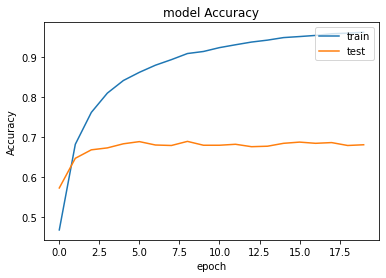

In [10]:
#plotting the loss
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show

# Model Serialisation (saving the model)

In [11]:
#save model to disk 
model_json = model.to_json()
with open('up/usc_8020_CNN_all_aug.json','w') as json_file:
    json_file.write(model_json)

# Model Validation


In [12]:
#loading the json file and model architecture
json_file = open('up/usc_8020_CNN_all_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into the new mode
loaded_model.load_weights('up/usc_8020_CNN_all_aug.h5')
print('Loaded model from disk')

loaded_model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics =['accuracy'])

score = loaded_model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
52/52 [==============================] - 2s 29ms/step - loss: 1.4041 - accuracy: 0.6891
accuracy: 68.91%


In [13]:
preds = loaded_model.predict(X_test, batch_size=1, verbose=1)
preds = preds.argmax(axis=1)
preds

1653/1653 [==============================] - 5s 3ms/step


array([9, 1, 1, ..., 2, 2, 2])

In [14]:
#The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure

#predictions
#preds = preds.astype(int).flatten()
preds = le.inverse_transform(preds)
preds= pd.DataFrame({'predicted_values': preds})

#Actual labels

actual = y_test.argmax(axis=1)
#actual = actual.astype(int).flatten()
actual = le.inverse_transform(actual)
actual = pd.DataFrame({'actual_values': actual})

#combine both in one dataframe
final_df = actual.join(preds)
final_df.head()

,actual_values,predicted_values
0,1,9
1,1,1
2,1,1
3,1,1
4,1,9


[]

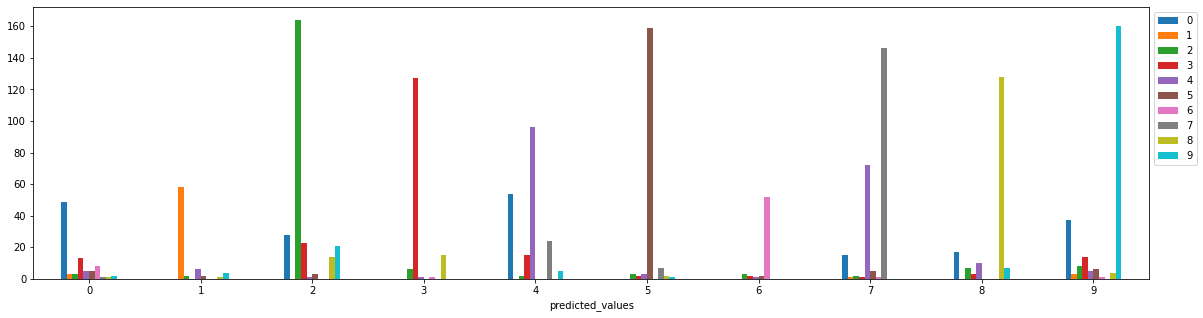

In [15]:
#write out predictions to disk
#final_df.to_csv('usc_8020_DNN_pred.csv', index=False)
ddf = final_df.groupby('predicted_values')['actual_values'].value_counts()
#final_df.groupby('actual_values').count()

ax = ddf.unstack().plot(kind='bar',figsize=(20,5), rot = 0)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [16]:
#Classification report
classes = final_df.actual_values.unique()
classes.sort()
print(classification_report(final_df.actual_values, final_df.predicted_values))

              precision    recall  f1-score   support

           0       0.54      0.24      0.34       200
           1       0.79      0.89      0.84        65
           2       0.65      0.82      0.72       200
           3       0.85      0.64      0.73       200
           4       0.49      0.48      0.48       200
           5       0.90      0.87      0.89       182
           6       0.87      0.83      0.85        63
           7       0.60      0.82      0.69       178
           8       0.74      0.78      0.76       165
           9       0.67      0.80      0.73       200

    accuracy                           0.69      1653
   macro avg       0.71      0.72      0.70      1653
weighted avg       0.69      0.69      0.68      1653



In [17]:

k_df = final_df.copy()
k_df = k_df.astype(str)
k_df['actual_values'] = k_df.actual_values.replace({          
                                        '0.0' :   'air_conditioner',
                                        '1.0' :  'car_horn',
                                        '2.0' :  'children_playing',
                                        '3.0' :  'dog_bark' ,      
                                        '4.0' :  'drilling',       
                                        '5.0' :  'engine_idling',  
                                        '6.0' :  'gun_shot',
                                        '7.0' :  'jackhammer',     
                                        '8.0' :  'siren', 
                                        '9.0' :  'street_music'
                                                         })
k_df['predicted_values'] = k_df.predicted_values.replace({
                                        '0.0' :   'air_conditioner',
                                        '1.0' :  'car_horn',
                                        '2.0' :  'children_playing',
                                        '3.0' :  'dog_bark' ,      
                                        '4.0' :  'drilling',       
                                        '5.0' :  'engine_idling',  
                                        '6.0' :  'gun_shot',
                                        '7.0' :  'jackhammer',     
                                        '8.0' :  'siren', 
                                        '9.0' :  'street_music'
                                                         })


classes = k_df.actual_values.unique()
classes.sort()

In [18]:
#k_df = k_df.astype(str)

k_df.actual_values.value_counts()


4    200
3    200
0    200
9    200
2    200
5    182
7    178
8    165
1     65
6     63
Name: actual_values, dtype: int64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


0.6890502117362372


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


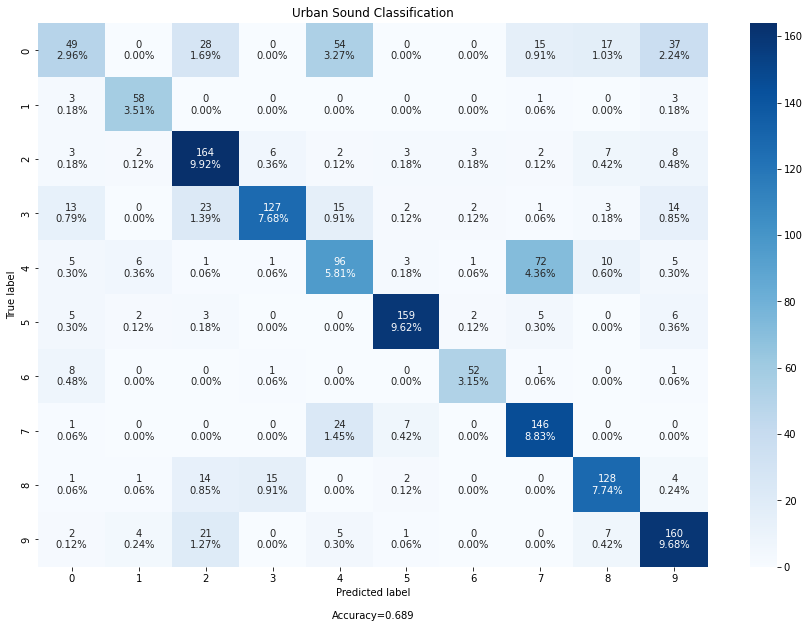

In [19]:
#final_df = pd.read_csv("kr_13_p.csv")
classes = k_df.actual_values.unique()
classes.sort()

#confusion matrix
c = confusion_matrix(k_df.actual_values, k_df.predicted_values)
print(accuracy_score(k_df.actual_values, k_df.predicted_values))
make_confusion_matrix(c, group_names=['True Values','Predicted Value'], categories=classes, figsize =(15,10), title='Urban Sound Classification')